In [1]:
import pandas as pd

In [16]:
# load every dataset in the db folder and merge them into one
import os

DATA_DIR = '../../db'

db = pd.DataFrame()
dataset_label = pd.Series()
for filename in os.listdir(DATA_DIR):
    if not filename.endswith('.parquet'):
        continue

    # read csv
    df = pd.read_parquet(os.path.join(DATA_DIR, filename))

    # append to dfs
    db = pd.concat([db, df])
    tmp = pd.Series([filename[:-8]] * len(df), index=df.index, name='dataset')
    dataset_label = pd.concat([dataset_label, tmp])

# concat dfs
db = db.dropna(axis=1)

/opt/anaconda3/envs/bio/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


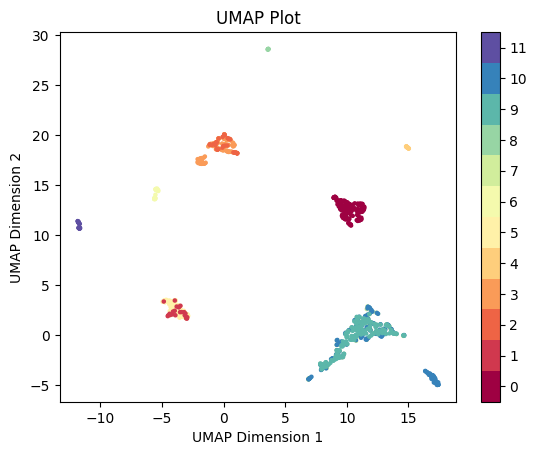

In [26]:
import umap
import numpy as np
import matplotlib.pyplot as plt

# Create UMAP embedding
umap_embedding = umap.UMAP().fit_transform(db.dropna(axis=1))

# Plot UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(dataset_label).codes, cmap='Spectral', s=5)
plt.title('UMAP Plot')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(boundaries=np.arange(13)-0.5).set_ticks(np.arange(12))
plt.show()